In [20]:
import pandas as pd
import zipfile




In [21]:
# Load GTFS ZIP
with zipfile.ZipFile("unitrans.zip", "r") as zip_ref:
    zip_ref.extractall("gtfs_data")

# Load key files
stops = pd.read_csv("gtfs_data/stops.txt")
stop_times = pd.read_csv("gtfs_data/stop_times.txt")
trips = pd.read_csv("gtfs_data/trips.txt")
routes = pd.read_csv("gtfs_data/routes.txt")
calendar = pd.read_csv("gtfs_data/calendar.txt")

In [22]:
# Merge to get route names with stop times
merged = stop_times.merge(trips, on="trip_id").merge(routes, on="route_id").merge(stops, on="stop_id")

# Sample: filter for Route V
route_v = merged[merged['route_short_name'] == 'V']

# Convert arrival_time to datetime (optional)
# Drop rows where arrival_time is missing
route_v = route_v.dropna(subset=['arrival_time'])

# Extract hour from arrival_time (first two characters before ":") and convert to int
route_v['arrival_hour'] = route_v['arrival_time'].str.split(':').str[0].astype(int)

route_v['arrival_hour'] = route_v['arrival_time'].str[:2].astype(int)

# Group by hour
hourly_counts = route_v.groupby('arrival_hour').size().reset_index(name='stop_count')


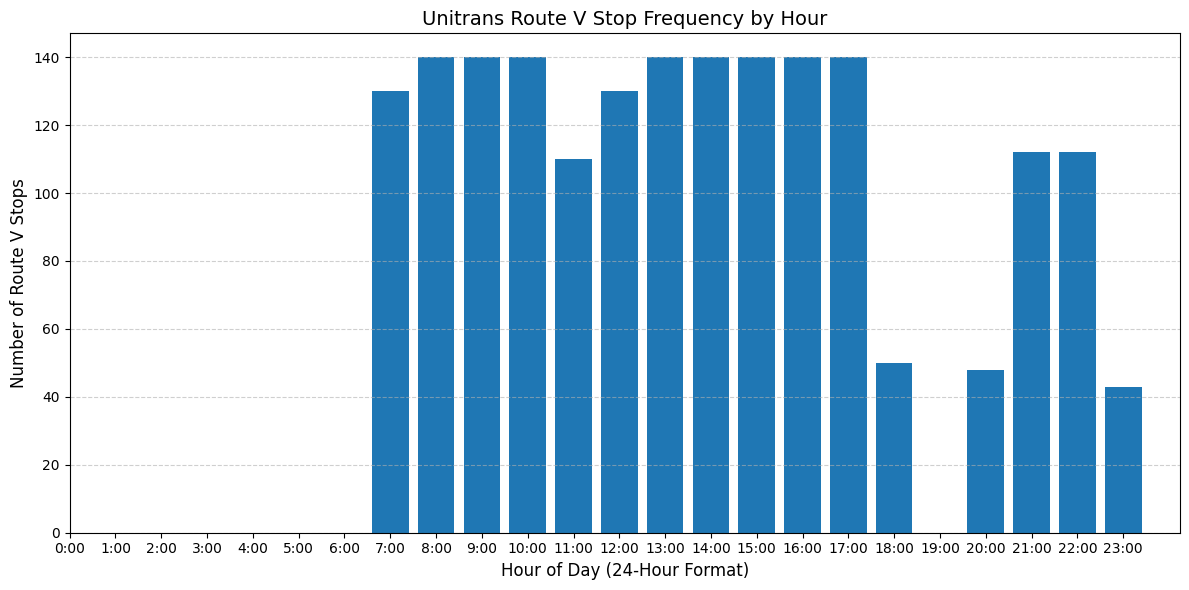

In [23]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
os.makedirs("images", exist_ok=True)

plt.figure(figsize=(12, 6))
plt.bar(hourly_counts['arrival_hour'], hourly_counts['stop_count'], width=0.8)

plt.xlabel('Hour of Day (24-Hour Format)', fontsize=12)
plt.ylabel('Number of Route V Stops', fontsize=12)
plt.title('Unitrans Route V Stop Frequency by Hour', fontsize=14)

plt.xticks(range(0, 24), labels=[f'{h}:00' for h in range(0, 24)])  # nicer tick labels
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("images/route_v_frequency_cleaned.png")
plt.show()


In [24]:


# List of routes you want to analyze
routes_to_analyze = ['D', 'G', 'V', 'W']

# Dictionary to store hourly counts
route_hourly_data = {}

for route in routes_to_analyze:
    route_data = merged[merged['route_short_name'] == route]
    route_data = route_data.dropna(subset=['arrival_time'])

    # Get hour from arrival_time
    route_data['arrival_hour'] = route_data['arrival_time'].str.split(':').str[0].astype(int)

    # Count number of stops per hour
    hourly_counts = route_data.groupby('arrival_hour').size().reset_index(name='stop_count')
    route_hourly_data[route] = hourly_counts.set_index('arrival_hour')['stop_count']

# Combine all into one DataFrame
combined_df = pd.DataFrame(route_hourly_data).fillna(0).astype(int)
combined_df = combined_df.sort_index()


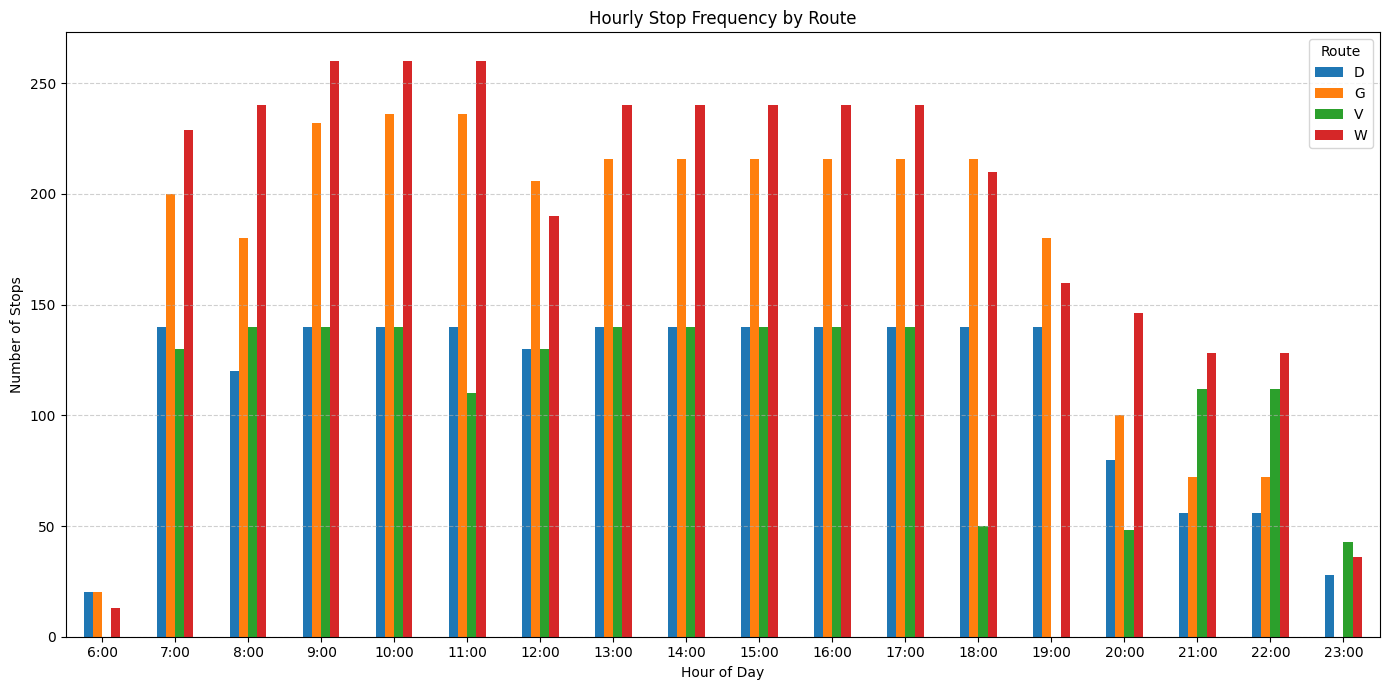

In [25]:
combined_df.plot(kind='bar', figsize=(14, 7))
plt.title('Hourly Stop Frequency by Route')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Stops')

# Set tick labels to "7:00", "8:00", etc.
plt.xticks(ticks=range(len(combined_df.index)), labels=[f"{h}:00" for h in combined_df.index], rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Route')
plt.tight_layout()
plt.savefig("images/grouped_route_frequency.png")
plt.show()



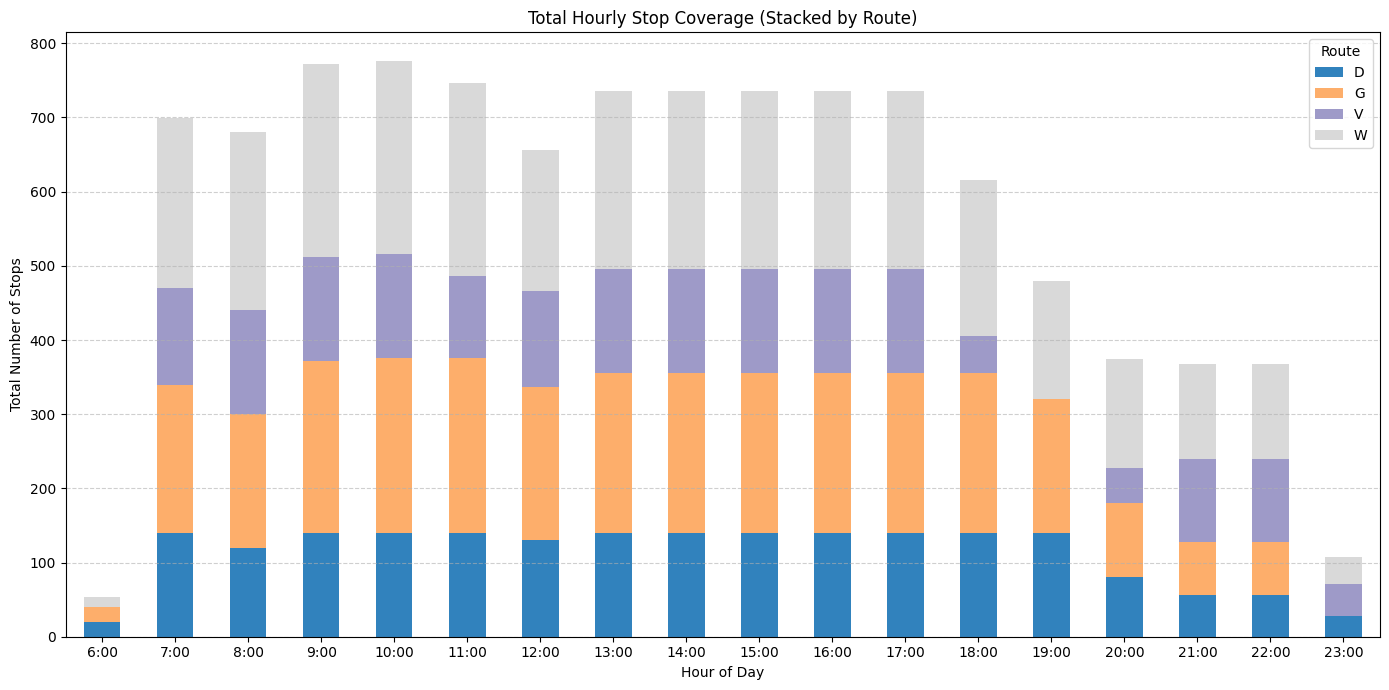

In [26]:
combined_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20c')
plt.title('Total Hourly Stop Coverage (Stacked by Route)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Number of Stops')

# Set tick labels to "7:00", "8:00", etc.
plt.xticks(ticks=range(len(combined_df.index)), labels=[f"{h}:00" for h in combined_df.index], rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Route')
plt.tight_layout()
plt.savefig("images/stacked_route_coverage.png")
plt.show()
